# Unit 6. Essential Deep Learning Tips & Tricks

# Exercise 1: Learning Rate Warmup

In [1]:
!pip install lightning-bolts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 25.2 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.1.4
    Uninstalling pytorch-lightning-2.1.4:
      Successfully uninstalled pytorch-lightning-2.1.4

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
%load_ext watermark
%watermark -p torch,lightning,pl_bolts --conda

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


torch    : 2.1.2+cu121
lightning: 2.1.4
pl_bolts : 0.7.0

conda environment: cloudspace



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_

In [2]:
import lightning as L
import torch
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, PyTorchMLP

In [3]:
num_epochs = 100

## Cosine annealing with 1-cycle schedule

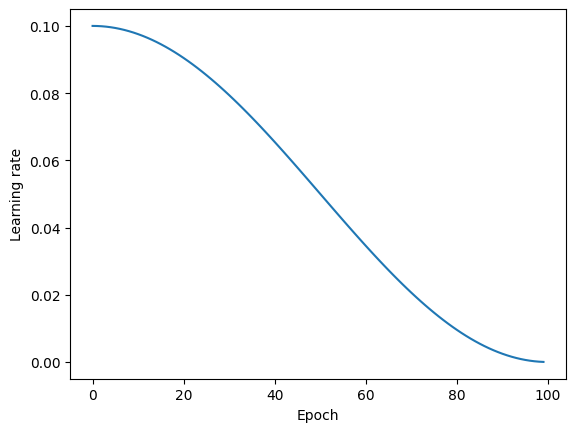

In [4]:
import matplotlib.pyplot as plt

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.plot(lrs)
#plt.savefig("cosine-1cycle-epoch.pdf")
plt.show()

/tmp/ipykernel_6997/1273185828.py:6: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=20, max_epochs=num_epochs)


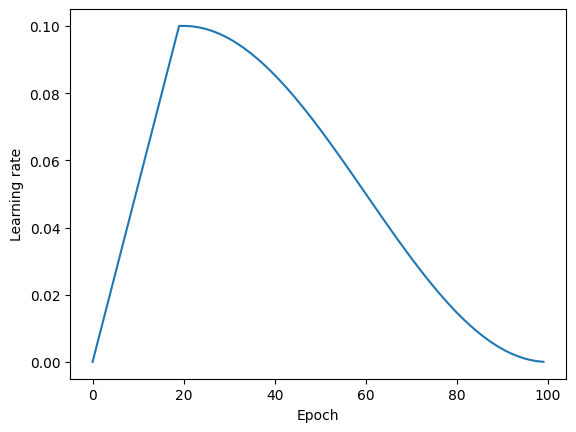

In [7]:
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR


model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=20, max_epochs=num_epochs)

lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.plot(lrs)
#plt.savefig("cosine-1cycle-epoch.pdf")
plt.show()

In [8]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, num_epochs):  # New!
        super().__init__()

        self.learning_rate = learning_rate
        self.num_epochs = num_epochs  # New!
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self): # New! 
        opt = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        sch = LinearWarmupCosineAnnealingLR(opt, warmup_epochs=20, max_epochs=self.num_epochs)

        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

# !!! No Modification Required Below Here !!!

In [9]:
L.seed_everything(123)
dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(
    model=pytorch_model,
    learning_rate=0.1,
    num_epochs=num_epochs) # New!

trainer = L.Trainer(
    max_epochs=num_epochs,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model=lightning_model, datamodule=dm)

Missing logger folder: logs/my-model
/tmp/ipykernel_6997/1719319592.py:50: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  sch = LinearWarmupCosineAnnealingLR(opt, warmup_epochs=20, max_epochs=self.num_epochs)

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.6 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.6 K    Trainable params
0         Non-trainable params
15.6 K    Total params
0.062     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


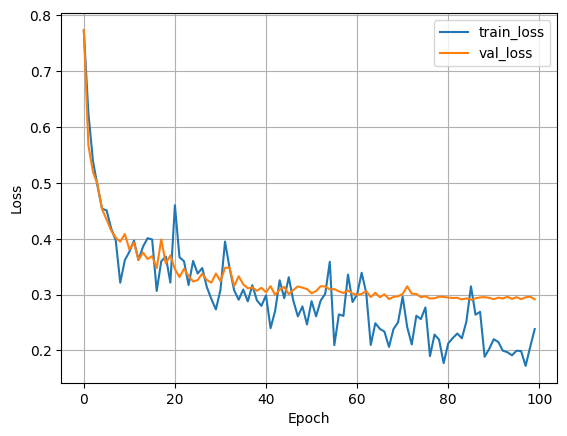

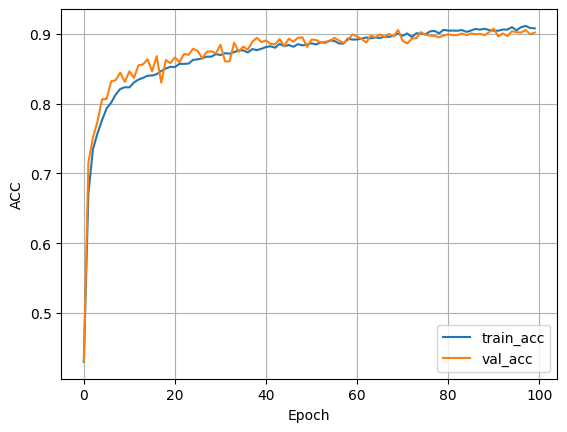

In [11]:
### Plot
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig("suggest_acc.pdf")

plt.show()

In [12]:
trainer.test(model=lightning_model, datamodule=dm)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8912500143051147     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8912500143051147}]